### Hierarchical predicition task. 
One-dimensional observation space. Two hierarchical levels. 
This code uses the algorithm of alternating learning and inference to discover latents induced by sudden changes in the env.


In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import gym
import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import defaultdict
import os, sys
root = os.getcwd()
sys.path.append(root)
sys.path.append('..')

import matplotlib as mpl
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['font.size'] = 8
# mpl.rcParams['font.family'] = 'serif'
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

import utils.plot_utils as pltu
from logger import *
from utils.plot_utils import *
from plot_functions import *
from configs import *
from models.model_lstm import *
# import tasks.generative_1d
from tasks.hierarchical_gaussians_task import *
from train import *
from plot_functions import *

## Define a model 

In [3]:
# Initiate and maybe Train RNN 
train_model = False
horizon_long_short = 'short'
# horizon_long_short = 'long'
scale = 10
experiment = 10
config = Config(context_units = 4) # increase thalamus units
config.no_of_latents = 2
context_transition_functions = {7: 'two_sequences', 8: 'fixed_random_sequences', 9: 'experiment_9', 10: 'experiment_10'}
training_phase_1_config = {'context_transition_function':  context_transition_functions[experiment],
        'max_trials_per_block':int(scale*5), 'min_trials_per_block':int(scale*2),
        'context_switch_rate': 1/(scale*(5-3)), 'no_of_blocks':70}
config.training_phases= [{'start_ts': 1, 'config': training_phase_1_config}]
logger = Logger(config)
env = Generative_environment(config, experiment=experiment)
model = LSTM_model(config,hidden_size=100)
if horizon_long_short == 'long':
        horizon = training_phase_1_config['max_trials_per_block'] * (1+1)
else:
        horizon = 5
_use_oracle = False
_use_optimized_thalamus = False
if train_model:
        memory_buffer, losses = alternate_learning_inference(model, env, _use_oracle, config, 'WU', horizon, nn.MSELoss(), 0, logger)
        plot_behavior(memory_buffer, env, losses, config, _use_oracle )

Get the gradients from the model and plot their correlation with task latent variables (observation means and the type of 3 block sequence)

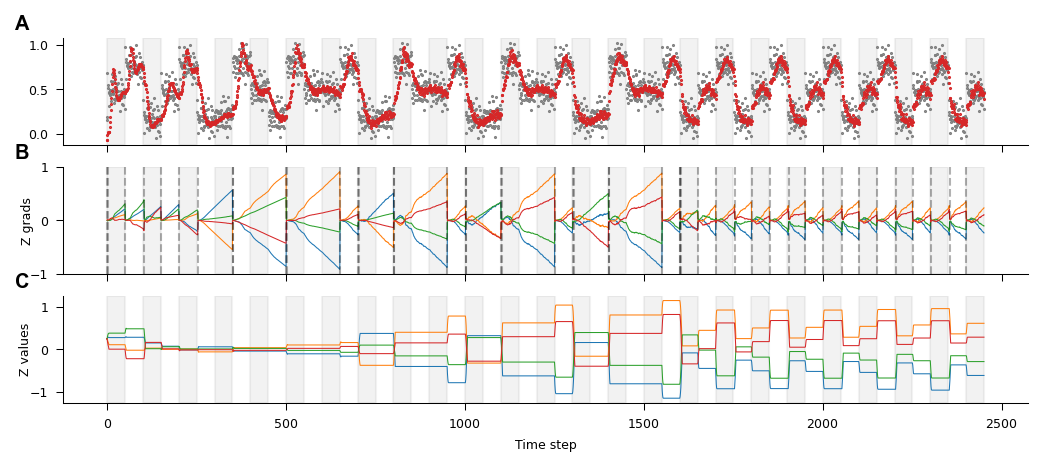

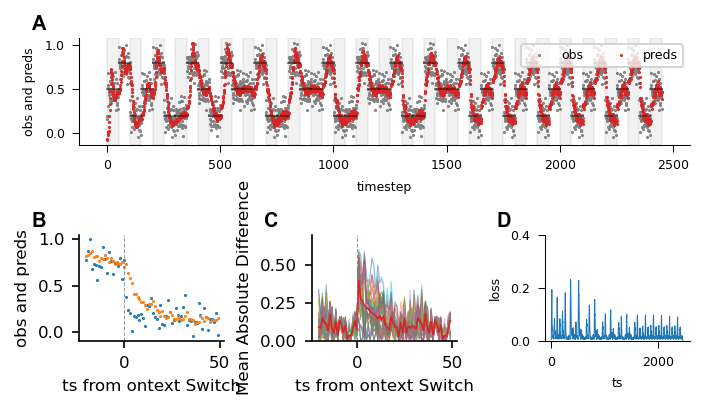

In [4]:
config.default_std = 0.1 # Control difficulty of task
config.LU_lr = 5
config.l2_loss = 0.004
input_distort = True

config.training_phases[0]['config']['no_of_blocks'] = 50
testing_env = Generative_environment(config, experiment=experiment)

if horizon_long_short == 'long':
        horizon = int(training_phase_1_config['max_trials_per_block'] * (1+1))
else:
        horizon = 5
optimizer = 'LU'
logger = Logger(config)
criterion = nn.MSELoss(reduction='none')
use_optimized_thalamus = False
config.backprop_only_last_timestep = False
config.accummulate_thalamus_temporally = False


testing_memory_buffer, testing_losses = alternate_learning_inference(model, testing_env,  config, horizon, criterion, logger, allow_weight_updates=True, use_optimized_thalamus= True, infer_switch =True, input_distort = False)

# ONLY USE two of the thalalmus_grads and thalalmus
# testing_memory_buffer.timestep_data['thalamus_grad'] = np.stack(testing_memory_buffer.timestep_data['thalamus_grad'])[...,2:]
# testing_memory_buffer.timestep_data['thalamus'] = np.stack(testing_memory_buffer.timestep_data['thalamus'])[...,2:]

plot_grads(testing_memory_buffer, testing_env, x1=50, x2=np.inf)
switch_detections = np.stack(testing_memory_buffer.timestep_data['switch_detections'])
# add switch detections to plot
# get the axis handle for the second subplot
axes = plt.gcf().get_axes()
ax = axes[1]
# plot the switch detection times as vertical lines
for i in range(switch_detections.shape[0]):
        ax.axvline(x=switch_detections[i], color='k', linestyle='--', linewidth = 1,  alpha=0.3)

prespecified_thalamus_untrained = np.stack(testing_memory_buffer.timestep_data['thalamus'])
# plot_modulations(testing_memory_buffer, testing_env, testing_losses, config, x1=50, x2=np.inf, latent_dim = 0, replace_context2_with_level2=True)
# plot_modulations(testing_memory_buffer, testing_env, testing_losses, config, x1=50, x2=np.inf, latent_dim = 2, replace_context2_with_level2=True)
# plot_dual_modulations(testing_memory_buffer, testing_env, testing_losses, config, x1=50, x2=np.inf, replace_context2_with_level2=True)
plot_behavior(testing_memory_buffer, testing_env, testing_losses, config, _use_oracle,)

Test performance of thalamus enabled
Testing now is done by simply running the RNN on the task. Its weights are frozen. 
However, at every time step z is updated along its gradients. If z is informative and can dictate model behavior, optimizing it should be sufficient to sovle the task. 


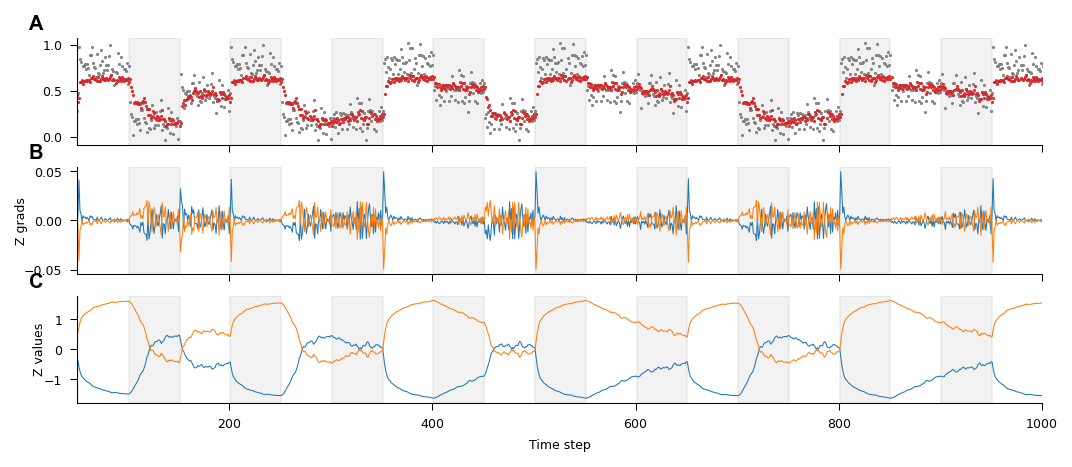

In [10]:
testing_env = Generative_environment(config, experiment=experiment)

if horizon_long_short == 'long':
        horizon = int(training_phase_1_config['max_trials_per_block'] * (1+1))
else:
        horizon = 5
optimizer = 'LU'
logger = Logger(config)
criterion = nn.MSELoss(reduction='sum')
_use_optimized_thalamus = True
config.backprop_only_last_timestep = False
config.accummulate_thalamus_temporally = False

testing_memory_buffer, testing_losses = adapt_model_v3(model, testing_env, _use_oracle, config, optimizer, horizon, criterion,
                                                0, logger, _use_optimized_thalamus=_use_optimized_thalamus,)
testing_memory_buffer.timestep_data['thalamus_grad'] = np.stack(testing_memory_buffer.timestep_data['thalamus_grad'])[...,:2]
testing_memory_buffer.timestep_data['thalamus'] = np.stack(testing_memory_buffer.timestep_data['thalamus'])[...,:2]
# plot_dual_modulations(testing_memory_buffer, testing_env, testing_losses, config, x1=50, x2=np.inf)
plot_grads(testing_memory_buffer, testing_env, x1=50, x2=1000)

# Try generalization

Now I test the model, allowed to update its z every time step, on the set of gaussians from -0.2 to 1.2 (in 0.1 steps) to test its ability to generalize. 

In [6]:
def run_exp_generalization_ili(model, _use_optimized_thalamus=True, novel_std=0.1, horizon = 5, lr = None, momentum = None, gradient_clipping = None, l2_loss = None, use_adam_optimizer = False):

    training_phase_1_config = {'context_transition_function':'fixed_alternating',
            'max_trials_per_block':int(scale*5), 'min_trials_per_block':int(scale*2),
            'context_switch_rate': 1/(scale*(5-3)), 'no_of_blocks': 8*15} # 8 * 15 to match the previous experiments 
    config.training_phases= [{'start_ts': 1, 'config': training_phase_1_config}]
    testing_env = Generative_environment(config, experiment=3, novel_std=novel_std)

    optimizer = 'LU'
    # update optimizer config
    if l2_loss: config.l2_loss = l2_loss
    config.LU_optimizer = 'Adam' if use_adam_optimizer else 'SGD'
    config.momentum = momentum
    if lr: config.lr = lr
    model.config= config
    model.LU_optimizer = model.get_LU_optimizer() # this reinstates the optimizer with the new config values
    
    logger = Logger(config)
    criterion = nn.MSELoss(reduction='sum')
    _use_optimized_thalamus = True
    config.backprop_only_last_timestep = False
    config.accummulate_thalamus_temporally = True
    testing_memory_buffer, testing_losses = adapt_model_v3(model, testing_env, _use_oracle, config, optimizer, horizon, criterion,
                                                    0, logger, _use_optimized_thalamus=_use_optimized_thalamus,)
    testing_memory_buffer.timestep_data['thalamus_grad'] = np.stack(testing_memory_buffer.timestep_data['thalamus_grad'])[...,:2]
    testing_memory_buffer.timestep_data['thalamus'] = np.stack(testing_memory_buffer.timestep_data['thalamus'])[...,:2]
    # plot_dual_modulations(testing_memory_buffer, testing_env, testing_losses, config, x1=50, x2=np.inf)
#     plot_grads(testing_memory_buffer, testing_env, x1=0, x2=np.inf)
    return testing_memory_buffer, testing_losses, testing_env

In [7]:
memory_buffer_RNN_cxt_var,  losses_RNN_cxt_var , env_RNN_cxt_var= run_exp_generalization_ili(model, _use_optimized_thalamus=True, novel_std=default_std, horizon = 5,
        use_adam_optimizer=True, lr=0.2, l2_loss=0.02)


NameError: name 'default_std' is not defined

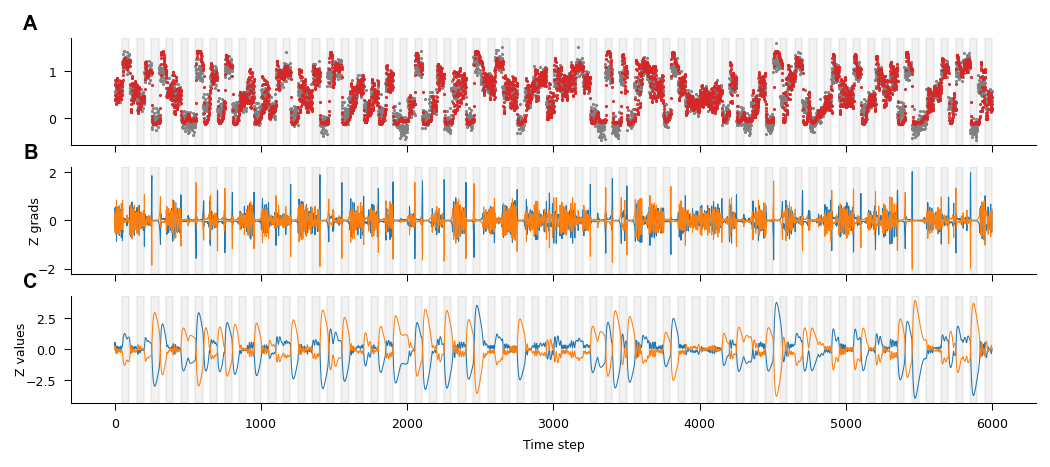

In [ ]:
plot_grads(memory_buffer_RNN_cxt_var, env_RNN_cxt_var, )

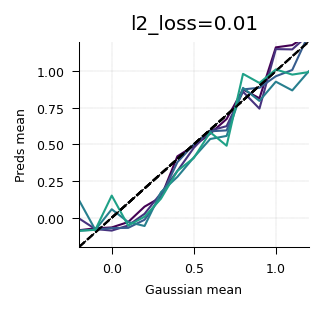

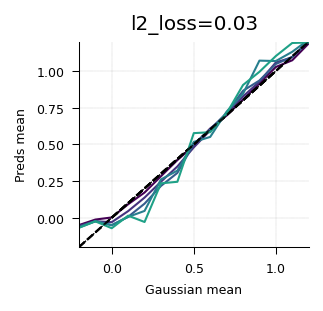

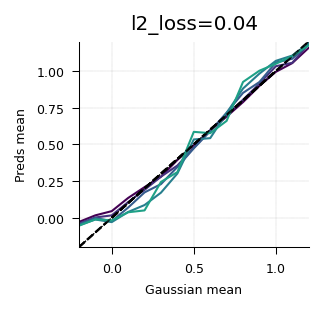

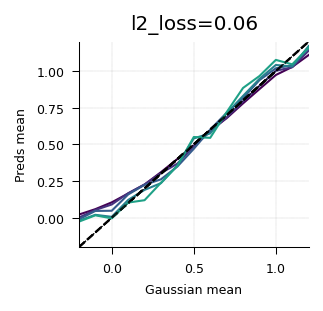

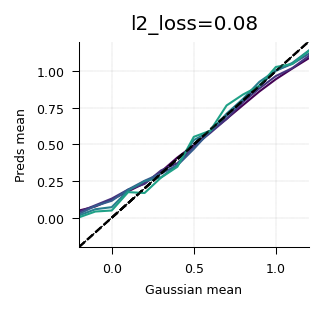

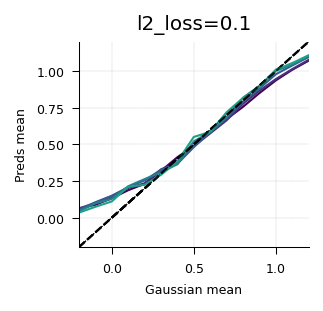

In [ ]:
def run_gen_exp(model, l2_loss=0.06, _use_optimized_thalamus=True):
    memory_buffers_RNN_cxt_var = []
    losseses_RNN_cxt_var = []
    envs_RNN_cxt_var = []
    local_stds = stds
    for std in local_stds:
        memory_buffer_RNN_cxt_var,  losses_RNN_cxt_var , env_RNN_cxt_var= run_exp_generalization_ili(model, _use_optimized_thalamus=_use_optimized_thalamus, novel_std=std, horizon = 5,
        use_adam_optimizer=True, lr=0.2, l2_loss=l2_loss)
        # memory_buffer_RNN_cxt_var,  losses_RNN_cxt_var , env_RNN_cxt_var= run_exp_generalization_ili(model, _use_optimized_thalamus=_use_optimized_thalamus, novel_std=std, horizon = 5,
        # use_adam_optimizer=False, lr=None, l2_loss=None)
        # lr = 0.1, momentum = 0.1, gradient_clipping = 0, l2_loss = 0.03)
        # )
        memory_buffers_RNN_cxt_var.append(memory_buffer_RNN_cxt_var)
        losseses_RNN_cxt_var.append(losses_RNN_cxt_var)
        envs_RNN_cxt_var.append(env_RNN_cxt_var)

    # fig.savefig('./exports/quantifiying_generalization_Cxt_VAR.pdf', dpi=300)
    fig, axes = plt.subplots(1,1,figsize = [5/2.53, 4.5/2.53])
    plot_all_generalization_lines(memory_buffers_RNN_cxt_var , envs_RNN_cxt_var, axes, title='RNN cxt var', stds=local_stds, means=means)
    axes.set_xlim(-0.2, 1.2)
    axes.set_ylim(-0.2, 1.2)
    axes.set_title(f'l2_loss={l2_loss}')
    
sweep_params = True
if sweep_params:
    for l2 in [0.01, 0.03, 0.04, 0.06, 0.08, 0.1]:
    # for l2 in [0.04, ]:
        run_gen_exp(model, l2)
        plt.show()